In [178]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import random
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from scipy.stats import norm
from sklearn.preprocessing import Normalizer,StandardScaler, LabelEncoder
from tensorflow_addons.losses import pinball_loss
from sklearn.metrics import mean_pinball_loss
from scipy import stats
import math

In [179]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
horizons = [36, 48 ,60, 72, 84]

# Read and preprocess data

In [180]:
data = pd.read_feather("data/berlin_data/historic_data/icon_eps_wind_10m.feather")
data.dropna(inplace=True)
data.head()

,init_tm,met_var,location,fcst_hour,obs_tm,obs,ens_1,ens_2,ens_3,ens_4,...,ens_33,ens_34,ens_35,ens_36,ens_37,ens_38,ens_39,ens_40,ens_mean,ens_var
0,2018-12-18 00:00:00+00:00,wind_10m,Berlin,0.0,2018-12-18 00:00:00+00:00,6.48,3.80,6.56,4.54,5.05,...,5.59,5.45,5.30,4.47,5.99,3.48,4.92,5.09,4.58675,0.565448
1,2018-12-18 00:00:00+00:00,wind_10m,Berlin,1.0,2018-12-18 01:00:00+00:00,6.12,3.68,7.03,5.06,5.33,...,4.92,5.18,4.98,4.88,6.39,3.74,5.18,4.85,4.69750,0.663747
2,2018-12-18 00:00:00+00:00,wind_10m,Berlin,2.0,2018-12-18 02:00:00+00:00,4.32,3.28,7.10,5.39,5.44,...,4.91,4.88,5.20,4.80,6.66,4.14,5.05,4.80,4.81650,0.830100
3,2018-12-18 00:00:00+00:00,wind_10m,Berlin,3.0,2018-12-18 03:00:00+00:00,5.04,3.47,7.45,6.11,5.66,...,5.37,4.58,5.30,4.86,6.96,4.41,5.26,4.74,5.01625,1.222111
4,2018-12-18 00:00:00+00:00,wind_10m,Berlin,4.0,2018-12-18 04:00:00+00:00,6.48,3.56,8.02,6.29,5.81,...,5.30,4.05,5.04,5.26,6.67,4.86,4.95,4.56,5.01600,1.355050


## Create positional encoding

In [181]:
pos_enc = pd.DataFrame(index=pd.DatetimeIndex(data["obs_tm"]))
pos_enc["Dayofyear"] = pos_enc.index.dayofyear
pos_enc["n_days"] = 365
pos_enc.loc[pos_enc.index.year==2020,"n_days"] = 366
#Calculate actual positional encoding
sin_encoding = np.sin(2*math.pi*pos_enc["Dayofyear"]/pos_enc["n_days"])
cos_encoding = np.cos(2*math.pi*pos_enc["Dayofyear"]/pos_enc["n_days"])
data["pos_enc_1"] = sin_encoding.to_numpy()
data["pos_enc_2"] = cos_encoding.to_numpy()

## Train, val, test split

In [182]:
train_val_dataframe, test_dataframe = train_test_split(data, test_size = 0.2, random_state = 1)
train_dataframe, val_dataframe = train_test_split(data, test_size = 0.2, random_state = 2)

### Normalize

In [183]:
def normalize(dataframe, label_encoder = None,feature_scaler = None, target_scaler = None, learn = False):
    #Drop unused columns
    data = dataframe.copy()
    data.drop(["init_tm", "met_var", "location", "ens_mean", "ens_var", "obs_tm"], axis = 1, inplace = True)
    data = data.to_numpy()
    if learn == True:
        label_encoder = LabelEncoder()
        feature_scaler = StandardScaler()
        target_scaler = StandardScaler()
        #Learn label encoding for horizons
        label = label_encoder.fit_transform(data[:,0])
        #Learn target scaling
        target_scaled = target_scaler.fit_transform(data[:,1].reshape(-1,1))
        #Learn feature scaling
        feature_scaled = feature_scaler.fit_transform(data[:,2:])
        #Append
        data[:,0] = label
        data[:,1] = target_scaled.reshape(-1)
        data[:,2:] = feature_scaled
        
        return data, label_encoder, feature_scaler, target_scaler
    
    else:
        #Learn labels
        label = label_encoder.transform(data[:,0])
        #Scale target
        target_scaled = target_scaler.transform(data[:,1].reshape(-1,1))
        #Scale features
        feature_scaled = feature_scaler.transform(data[:,2:])
        #Append
        data[:,0] = label
        data[:,1] = target_scaled.reshape(-1)
        data[:,2:] = feature_scaled
        
        return data

In [184]:
train_val, label_encoder, feature_scaler, target_scaler = normalize(train_val_dataframe, learn = True)
train= normalize(train_dataframe, label_encoder, feature_scaler, target_scaler)
test = normalize(test_dataframe, label_encoder, feature_scaler, target_scaler)
val = normalize(val_dataframe, label_encoder, feature_scaler, target_scaler)
#Number of encodings
n_encodings = len(np.unique(train[:,0]))

In [185]:
def convert_format(input_data, predict = False):
    #Extract forecast embedding
    horizon_emb = input_data[:,0]
    
    if predict == False:        
        #Extract features
        features = input_data[:,2:]
        # Extract target
        target = np.expand_dims(input_data[:,1],1)
        return [features, horizon_emb], target
    else:
        #Extract features
        features = input_data[:,1:]
        return [features, horizon_emb]

In [186]:
train_data, train_target = convert_format(train)
val_data, val_target = convert_format(val)
test_data, test_target = convert_format(test)

# Create Model

In [187]:
BATCH_SIZE = 1024
EPOCHS = 100
learning_rate = 0.001

In [188]:
class base_model(tf.keras.Model):    
    def __init__(self, n_embeddings = n_encodings):
        super(base_model, self).__init__()
        #Embedding layers
        self.embedding = Embedding(input_dim = n_embeddings, output_dim = 4)
        #Create Dense layers
        self.hidden = Dense(25, activation = "relu")
        self.out = Dense(1, activation = "linear")

    def call(self, input_data):
        #Extract data
        features, horizon_emb = input_data
        #Calculate embedding
        emb = self.embedding(horizon_emb)
        emb = tf.squeeze(emb, axis = 1)
        conc = Concatenate(axis = 1)([features, emb])
        #Calculate output
        output = self.hidden(conc)
        output = self.out(output)

        return output

In [189]:
def train_model(model, quantile, train_data, train_target, validation_data, batch_size, epochs, learning_rate):
    #Define optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    #Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, min_delta = 1e-5)
    #Compile model
    model.compile(optimizer = optimizer, loss = lambda true,pred: pinball_loss(true, pred, tau = quantile))
    model.fit(x = train_data, y = train_target, validation_data = validation_data, epochs = epochs, batch_size = batch_size, callbacks = [callback], shuffle = True, verbose = False)

In [190]:
def create_all_models(train_data, train_target, validation_data, batch_size = BATCH_SIZE, epochs = EPOCHS, learning_rate = learning_rate, quantiles = quantiles):
    models = []
    for quantile in quantiles:
        model = base_model()
        train_model(model, quantile, train_data, train_target, validation_data, batch_size, epochs, learning_rate)
        print("Training finished for quantile: {}".format(quantile))
        models.append(model)
    return models

In [191]:
trained_models = create_all_models(train_data, train_target, (val_data, val_target))

Training finished for quantile: 0.025
Training finished for quantile: 0.25
Training finished for quantile: 0.5
Training finished for quantile: 0.75
Training finished for quantile: 0.975


# Predict test data

## Evaluate pinball loss

In [192]:
predictions = []
for cnt,_ in enumerate(quantiles):
    pred = trained_models[cnt].predict(test_data)
    predictions.append(pred)

In [194]:
for cnt,quantile in enumerate(quantiles):
    loss = mean_pinball_loss(test_target.reshape(-1), predictions[cnt].reshape(-1), alpha = quantile)
    print("Pinball loss for quantile {} : \t {}".format(quantile,loss))

Pinball loss for quantile 0.025 : 	 0.029424791892523953
Pinball loss for quantile 0.25 : 	 0.17252209940170374
Pinball loss for quantile 0.5 : 	 0.22434974453773232
Pinball loss for quantile 0.75 : 	 0.1854476382626945
Pinball loss for quantile 0.975 : 	 0.0372500349377611


## Evaluate pinball loss on naive prediction

In [195]:
naive_pred = np.quantile(test_data[0], quantiles, axis = 1)
for cnt,quantile in enumerate(quantiles):
    loss = mean_pinball_loss(np.squeeze(test_target), naive_pred[cnt], alpha = quantile)
    print("Pinball loss for quantile {} : \t {}".format(quantile,loss))

Pinball loss for quantile 0.025 : 	 0.04988347068334811
Pinball loss for quantile 0.25 : 	 0.1936006566940803
Pinball loss for quantile 0.5 : 	 0.23766786865360237
Pinball loss for quantile 0.75 : 	 0.20189037004814897
Pinball loss for quantile 0.975 : 	 0.06287948461940582


## Check plausability of model

In [196]:
for cnt,pred in enumerate(predictions):
    q_smaller = (pred > test_target).sum()
    emp_quant = q_smaller / pred.size
    print("Quantile met for quantile = {}: \t {} %".format(quantiles[cnt], np.round(emp_quant,4)*100))

Quantile met for quantile = 0.025: 	 2.16 %
Quantile met for quantile = 0.25: 	 24.349999999999998 %
Quantile met for quantile = 0.5: 	 52.739999999999995 %
Quantile met for quantile = 0.75: 	 75.62 %
Quantile met for quantile = 0.975: 	 97.3 %


## Check relationship with time

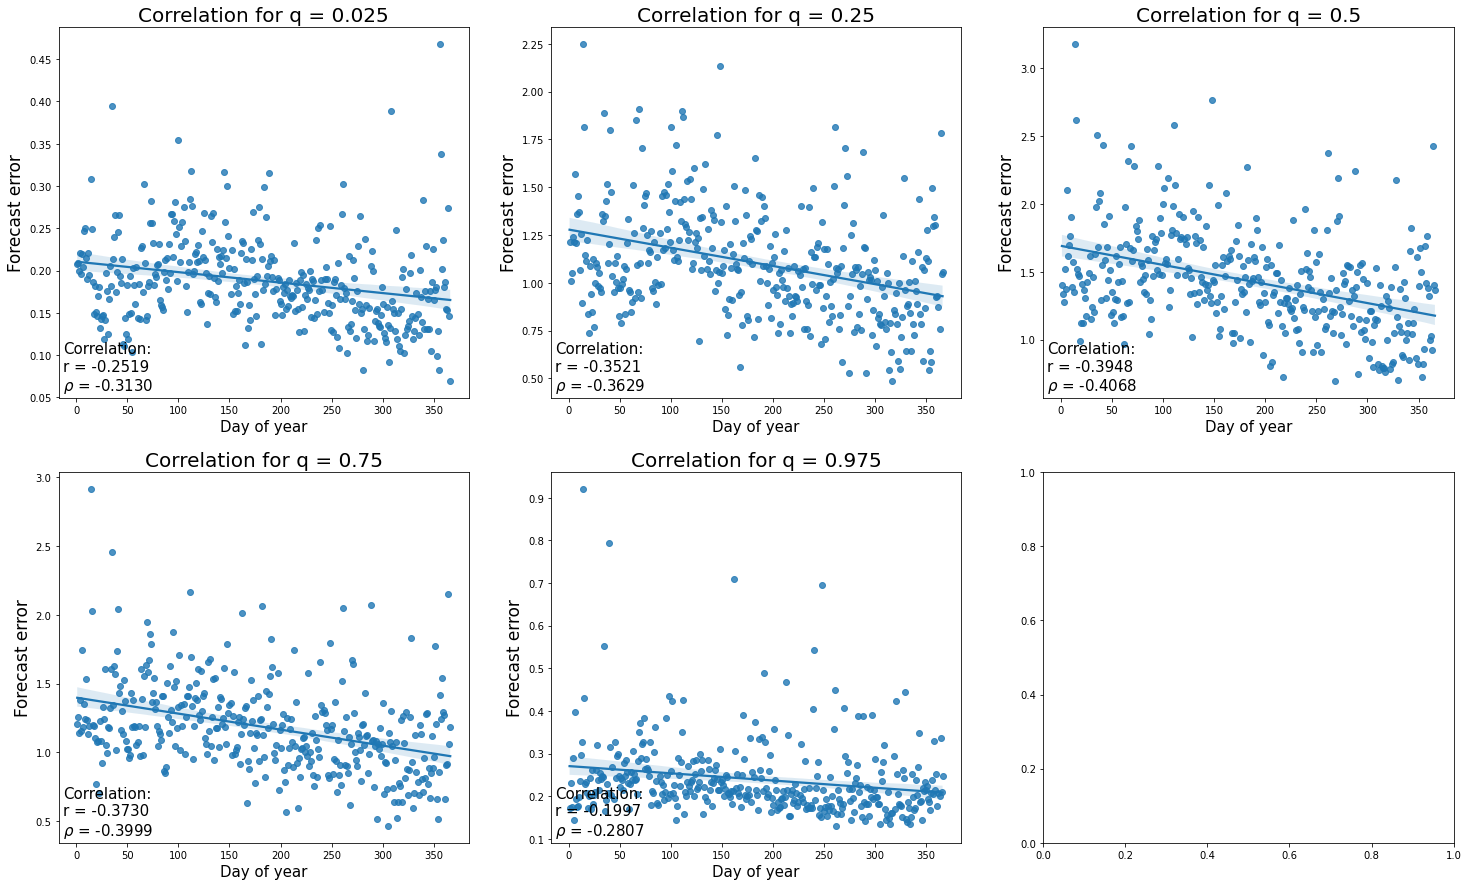

In [197]:
fig, ax = plt.subplots(2,3,figsize=(25,15))
ax = ax.ravel()
for cnt, quantile in enumerate(quantiles):
    #Renormalize and calculate forecast error
    error = mean_pinball_loss(test_dataframe["obs"].to_numpy().reshape(1,-1), target_scaler.inverse_transform(predictions[cnt]).reshape(1,-1), multioutput="raw_values", alpha=quantile)
    test_dataframe["Forecast_error"] = error
    test_dataframe["day"] = pd.DatetimeIndex(test_dataframe["obs_tm"]).dayofyear
    plot = test_dataframe.groupby("day").mean().reset_index()

    sns.regplot(x = "day", y = "Forecast_error", data=plot, ax = ax[cnt])
    ax[cnt].set_xlabel("Day of year",size = 15)
    ax[cnt].set_ylabel("Forecast error", size = 17)
    ax[cnt].set_title("Correlation for q = {}".format(quantile),size = 20)
    r = stats.pearsonr(plot["day"], plot["Forecast_error"])[0]
    rho = stats.spearmanr(plot["day"], plot["Forecast_error"])[0]
    ax[cnt].annotate('Correlation:\nr = {:.4f}\n'.format(r)+r'$\rho$ = {:.4f}'.format(rho),xy = (.01,.02), xycoords=ax[cnt].transAxes, size = 15)
    
#plt.savefig("wind_time_correlation_corrected_plot.pdf", dpi=300)

# Predict new data

## Train on complete data without test set

In [20]:
train_data, train_target = convert_format(train_val)
val_data, val_target = convert_format(test)

In [21]:
trained_models = create_all_models(train_data, train_target, (val_data, val_target))

Training finished for quantile: 0.025
Training finished for quantile: 0.25
Training finished for quantile: 0.5
Training finished for quantile: 0.75
Training finished for quantile: 0.975


## Predict new data

In [22]:
#Set current date
current_date = date.today().strftime("%Y%m%d")
path = "data/berlin_data/icon_data/icon-eu-eps_{}00_wind_mean_10m_Berlin.txt".format(current_date)
new_data = pd.read_csv(path.format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data.columns = new_data.columns.str.replace(" ", "")
# Normalize and get horizons
new_data = new_data[new_data["fcst_hour"].isin(horizons)].to_numpy()
new_data[:,1:] = feature_scaler.transform(new_data[:,1:])

In [23]:
pred_data = convert_format(new_data, predict = True)

In [24]:
#Prepare dataframe
final_prediction = pd.DataFrame(columns = ["forecast_date","target","horizon","q0.025","q0.25","q0.5","q0.75","q0.975"], index = np.arange(0,5))
final_prediction["forecast_date"] = datetime.today().strftime("%Y-%m-%d")
final_prediction["horizon"] = ["{} hour".format(x) for x in horizons]
final_prediction["target"] = "wind"

In [25]:
for cnt, quantile in enumerate(quantiles):
    #Get prediction
    prediction = trained_models[cnt].predict(pred_data)
    #Retransform
    final_pred = target_scaler.inverse_transform(prediction)
    final_prediction.loc[:,"q{}".format(quantile)] = final_pred

In [26]:
final_prediction

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2021-11-24,wind,36 hour,6.291183,10.456472,12.625645,14.613970,19.014479
1,2021-11-24,wind,48 hour,8.303682,12.899690,14.896458,18.187073,22.069714
2,2021-11-24,wind,60 hour,6.005039,11.021708,11.242007,14.934902,22.125204
3,2021-11-24,wind,72 hour,4.366765,10.022429,14.965999,19.421743,24.736071
4,2021-11-24,wind,84 hour,5.366802,12.509247,14.081431,18.042637,26.089764


In [27]:
new_data = pd.read_csv(path.format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data.columns = new_data.columns.str.replace(" ", "")
new_data[new_data["fcst_hour"].isin(horizons)].quantile(0.5, axis = 1)

36     9.91
48    12.60
52    10.41
56     9.84
58    11.07
Name: 0.5, dtype: float64

In [28]:
final_prediction.to_pickle("../evaluation/predictions/single/{}_{}".format("wind", date.today().strftime("%Y-%m-%d")))